In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
data=pd.read_csv('assignment-1-data.csv')
data.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,Dell,"Dell Latitude 5490 14"" Intel i5-8350U 32GB RAM...",14.0,32,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated Graphics,NaN,Excellent - Refurbished,299.99
1,HP,HP 15-dy2046ms Intel Core i3-1125G4 8GB/128GB ...,15.6,8,Intel Core i3 11th Gen.,Intel UHD Graphics,Integrated Graphics,1366 x 768,New,400.00
2,Samsung,"Samsung Galaxy Book Pro 15.6"" AMOLED Laptop (5...",15.6,8,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated Graphics,1920 x 1080,Open box,599.99
3,Dell,"Dell Latitude 5420 14"" Intel Core I5-1145G7 16...",14.0,16,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated Graphics,1920 x 1080,Open box,429.95
4,Lenovo,"Lenovo ThinkBook 14s-IWL Laptop 14"" i5 AMD Rad...",14.0,8,Intel Core i5 8th Gen.,AMD Radeon 540X,Dedicated Graphics,1920 x 1080,Very Good - Refurbished,269.95


section A:

Node construction:

In [3]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, gain=None, value=None):
        self.feature_index = feature_index  
        self.threshold = threshold          
        self.left = left                   
        self.right = right                  
        self.gain = gain                    
        self.value = value

In [4]:
class DecisionTreeClassifier_CUS:
    def __init__(self, min_samples_split=2, max_depth=2, random_state=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        dataset = np.column_stack((X, y))
        self.root = self._build_tree(dataset, current_depth=0)

    def _build_tree(self, dataset, current_depth):
        num_samples, num_features = np.shape(dataset)

        if num_samples >= self.min_samples_split and current_depth <= self.max_depth:
            best_split = self._find_best_split(dataset, num_samples, num_features-1)  
            if best_split['gain'] > 0:
                left_subtree = self._build_tree(best_split['left_data'], current_depth + 1)
                right_subtree = self._build_tree(best_split['right_data'], current_depth + 1)
                return Node(feature_index=best_split['feature'], threshold=best_split['threshold'], left=left_subtree, right=right_subtree, gain=best_split['gain'])

        leaf_value = self._calculate_leaf_value(dataset[:, -1])
        return Node(value=leaf_value)

    def _find_best_split(self, dataset, num_samples, num_features):
        best_split = {'gain': 0}
        max_gain = -float('inf')

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                left_data, right_data = self._split_data(dataset, feature_index, threshold)
                if len(left_data) > 0 and len(right_data) > 0:
                    y = dataset[:, -1]
                    current_gain = self._calculate_gain(y, left_data[:, -1], right_data[:, -1])
                    if current_gain > max_gain:
                        max_gain = current_gain
                        best_split = {
                            'feature': feature_index,
                            'threshold': threshold,
                            'left_data': left_data,
                            'right_data': right_data,
                            'gain': current_gain
                        }

        return best_split

    def _split_data(self, dataset, feature_index, threshold):
        left_data = np.array([row for row in dataset if row[feature_index] <= threshold])
        right_data = np.array([row for row in dataset if row[feature_index] > threshold])
        return left_data, right_data

    def _calculate_gain(self, parent, left_child, right_child, mode="entropy"):
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)

        if mode == "entropy":
            gain = self._entropy(parent) - (weight_left * self._entropy(left_child) + weight_right * self._entropy(right_child))
        else:
            gain = self._gini(parent) - (weight_left * self._gini(left_child) + weight_right * self._gini(right_child))

        return gain

    def _entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def _gini(self, y):
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    def _calculate_leaf_value(self, y):
        y = list(y)
        return max(set(y), key=y.count)

    def print_tree(self, node=None, indent=" "):
        if node is None:
            node = self.root

        if node.value is not None:
            print(indent + str(node.value))
        else:
            print(indent + "Feature " + str(node.feature_index) + " <= " + str(node.threshold) + "?")
            print(indent + "Left:")
            self.print_tree(node.left, indent + "  ")
            print(indent + "Right:")
            self.print_tree(node.right, indent + "  ")

    def predict(self, X):
        predictions = [self._predict(inputs, self.root) for inputs in X]
        return np.array(predictions)

    def _predict(self, inputs, node):
        if node.value is not None:
            return node.value
        feature_value = inputs[node.feature_index]
        if feature_value <= node.threshold:
            return self._predict(inputs, node.left)
        else:
            return self._predict(inputs, node.right)


In [5]:
class DecisionTreeRegressor_CUS:
    def __init__(self, min_samples_split=2, max_depth=2, random_state=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.random_state = random_state 

        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if num_samples >= self.min_samples_split and depth < self.max_depth:
            best_split = self._get_best_split(X, y, num_samples, num_features)
            if best_split["gain"] > 0:
                left_subtree = self._grow_tree(best_split["left_X"], best_split["left_y"], depth + 1)
                right_subtree = self._grow_tree(best_split["right_X"], best_split["right_y"], depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree)

        leaf_value = self._calculate_leaf_value(y)
        return Node(value=leaf_value)

    def _get_best_split(self, X, y, num_samples, num_features):
        best_split = {"gain": -1}
        for feature_index in range(num_features):
            try:
                feature_values = X[:, feature_index]
                possible_thresholds = np.unique(feature_values)
                for threshold in possible_thresholds:
                    left_indices = np.where(feature_values <= threshold)[0]
                    right_indices = np.where(feature_values > threshold)[0]
                    if len(left_indices) > 0 and len(right_indices) > 0:
                        left_y, right_y = y[left_indices], y[right_indices]
                        current_gain = self._calculate_gain(y, left_y, right_y)
                        if current_gain > best_split["gain"]:
                            best_split["feature_index"] = feature_index
                            best_split["threshold"] = threshold
                            best_split["left_X"] = X[left_indices]
                            best_split["left_y"] = y[left_indices]
                            best_split["right_X"] = X[right_indices]
                            best_split["right_y"] = y[right_indices]
                            best_split["gain"] = current_gain
            except Exception as e:
                print(f"Error occurred at feature_index {feature_index}: {e}")
                raise

        return best_split

    def _calculate_gain(self, parent, left_child, right_child, mode="mse"):
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)

        if mode == "mse":
            gain = self._mse(parent) - (weight_left * self._mse(left_child) + weight_right * self._mse(right_child))
        else:
            raise ValueError("Unknown mode: " + mode)

        return gain

    def _mse(self, y):
        mean = np.mean(y)
        mse = np.mean((y - mean) ** 2)
        return mse

    def _calculate_leaf_value(self, y):
        return np.mean(y)

    def _predict(self, inputs):
        node = self.root
        while node.value is None:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

In [6]:
class RandomForestClassifier_CUS:
    def __init__(self, n_estimators=100, min_samples_split=2, max_depth=2, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.random_state = np.random.RandomState(random_state)

    def fit(self, X, y):
        n_features = X.shape[1]
        if self.max_features is None:
            self.max_features = int(np.sqrt(n_features))
            
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = DecisionTreeRegressor_CUS(min_samples_split=self.min_samples_split, 
                                             max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = self.random_state.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        predictions = np.empty(tree_predictions.shape[1], dtype=int)
        
        for i in range(tree_predictions.shape[1]):
            counts = np.bincount(tree_predictions[:, i].astype(int))
            predictions[i] = np.argmax(counts)
        
        return predictions

In [7]:
class RandomForestRegressor_CUS:
    def __init__(self, n_estimators=100, min_samples_split=2, max_depth=2, random_state=None):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        rng = np.random.default_rng(seed=self.random_state)
        
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y, rng)
            tree = DecisionTreeRegressor_CUS(min_samples_split=self.min_samples_split,
                                             max_depth=self.max_depth,
                                             random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y, rng):
        n_samples = X.shape[0]
        indices = rng.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        median_predictions = np.median(tree_predictions, axis=0)
        return median_predictions

section B:

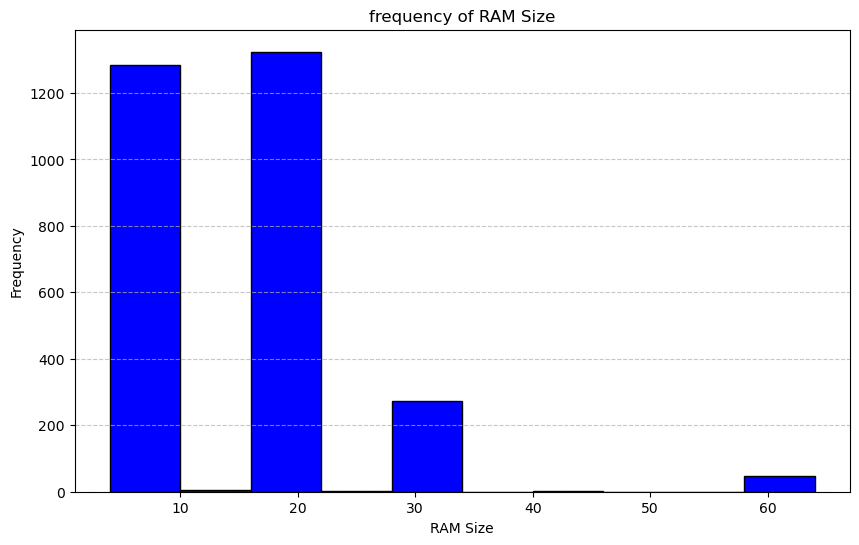

In [8]:
#comparing the frequency of number of devices from each ram
ram_size = data['RAM'].values
plt.figure(figsize=(10, 6))
plt.hist(ram_size, bins=10, color='blue', edgecolor='black')
plt.title('frequency of RAM Size')
plt.xlabel('RAM Size')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

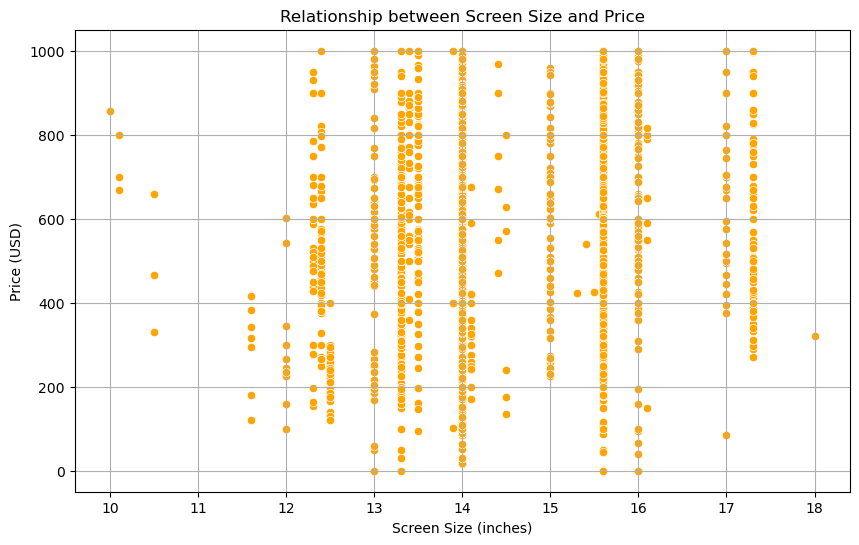

In [9]:
#i wanted to see how the screen size effect the price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Screen_Size', y='Price', data=data, color='orange')
plt.title('Relationship between Screen Size and Price')
plt.xlabel('Screen Size (inches)')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

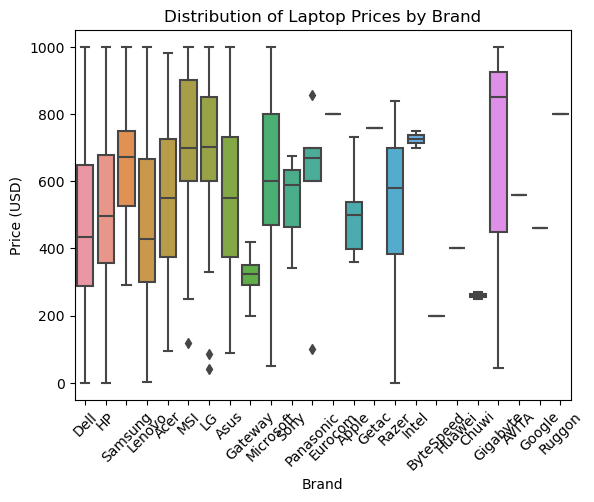

In [10]:
#i wanted to see how the brand and the price are related
sns.boxplot(x='Brand', y='Price', data=data)
plt.title('Distribution of Laptop Prices by Brand')
plt.xlabel('Brand')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.xticks(range(len(data['Brand'].unique())), data['Brand'].unique(), rotation=45)
plt.show()

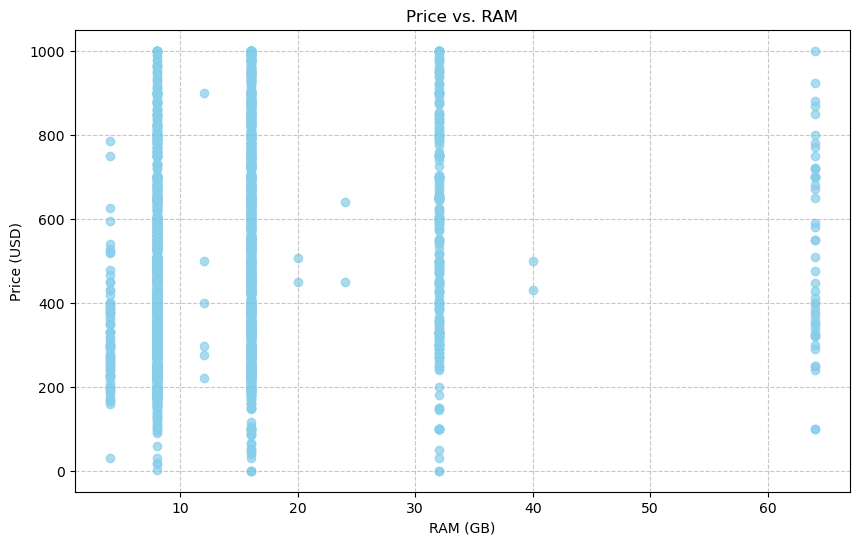

In [12]:
#i wanted to see how the price changes based on the ram size
plt.figure(figsize=(10, 6))
plt.scatter(data['RAM'], data['Price'], color='skyblue', alpha=0.7)
plt.title('Price vs. RAM')
plt.xlabel('RAM (GB)')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

In [13]:
missing_values_count = data.isnull().sum()
print("Number of missing values in each feature:")
print(missing_values_count)

Number of missing values in each feature:
Brand                    0
Product_Description      0
Screen_Size              0
RAM                      0
Processor                0
GPU                    347
GPU_Type               234
Resolution             387
Condition                0
Price                    0
dtype: int64


GPU and GPU_Type are categorical features so a common way is to replace missing values with the most frequent value of each feature.this ensures the most frequent values are preserved

In [14]:
# Replace missing values with the mode
data['GPU'].fillna(data['GPU'].mode()[0], inplace=True)
data['GPU_Type'].fillna(data['GPU_Type'].mode()[0], inplace=True)

Since Resolution is categorical and missing values are replaced with "0 x 0" to indicate that the resolution information was not available.

In [15]:
data['Resolution'].fillna('0 x 0', inplace=True)

In [16]:
missing_values_count = data.isnull().sum()
print("Number of missing values in each feature:")
print(missing_values_count)

Number of missing values in each feature:
Brand                  0
Product_Description    0
Screen_Size            0
RAM                    0
Processor              0
GPU                    0
GPU_Type               0
Resolution             0
Condition              0
Price                  0
dtype: int64


section C:

In [17]:
data['Condition'] = data['Condition'].apply(lambda x: 'New' if x in ['New', 'Open box'] else 'Refurbished')

df = pd.DataFrame(data)
columns_to_encode = ['Brand','Processor','GPU','GPU_Type','Resolution','Condition']
label_encoder = LabelEncoder()
for Feature in columns_to_encode:
    data[Feature] = label_encoder.fit_transform(data[Feature])


Features_Classification = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Price']

X_cls = data[Features_Classification].values
y_cls = data['Condition'].values

X_cls_train = X_cls[0:2058]
X_cls_val = X_cls[2058:2499]
X_cls_test = X_cls[2499:]
y_cls_train = y_cls[0:2058]
y_cls_val = y_cls[2058:2499]
y_cls_test = y_cls[2499:]


In [18]:
# Hyperparameter tuning for Decision Tree Classifier
min_samples_splits = [2, 5, 10]
max_depths = [5, 10, 15]
best_acc_dt = 0
best_params_dt = None
start_time_dt = time.time()

# Grid search for Decision Tree Classifier
for min_samples_split in min_samples_splits:
    for max_depth in max_depths:
        # Initialize and train the Decision Tree classifier
        dt_classifier = DecisionTreeClassifier_CUS(min_samples_split=min_samples_split, max_depth=max_depth)
        dt_classifier.fit(X_cls_train, y_cls_train)
        
        # Make predictions on the validation set
        y_pred_val_dt = dt_classifier.predict(X_cls_val)
        
        # Calculate current accuracy
        current_acc_dt = accuracy_score(y_cls_val, y_pred_val_dt)
        
        # Update best parameters if current accuracy is better
        if current_acc_dt > best_acc_dt:
            best_acc_dt = current_acc_dt
            best_params_dt = (min_samples_split, max_depth)


print(f"Best Parameters for Decision Tree Classifier: {best_params_dt}, Validation Accuracy: {best_acc_dt}")

# Train final Decision Tree Classifier with the best parameters
final_dt_classifier = DecisionTreeClassifier_CUS(min_samples_split=best_params_dt[0], max_depth=best_params_dt[1])
final_dt_classifier.fit(np.concatenate((X_cls_train, X_cls_val)), np.concatenate((y_cls_train, y_cls_val)))

# Predict on test set using final Decision Tree Classifier
y_pred_test_dt = final_dt_classifier.predict(X_cls_test)
final_accuracy_dt = accuracy_score(y_cls_test, y_pred_test_dt)


print(f"Final Accuracy on Test Set for Decision Tree Classifier: {final_accuracy_dt}")
print(f"Training Time for Decision Tree Classifier: {time.time() - start_time_dt} seconds")

cm_dt = confusion_matrix(y_cls_test, y_pred_test_dt)

# Extract True Positives, False Positives, True Negatives, False Negatives
TN_dt = cm_dt[0, 0]
FP_dt = cm_dt[0, 1]
FN_dt = cm_dt[1, 0]
TP_dt = cm_dt[1, 1]

# Calculate Sensitivity and Specificity
sensitivity_dt = TP_dt / (TP_dt + FN_dt)
specificity_dt = TN_dt / (TN_dt + FP_dt)


print(f"Sensitivity for Decision Tree Classifier: {sensitivity_dt}")
print(f"Specificity for Decision Tree Classifier: {specificity_dt}")

Best Parameters for Decision Tree Classifier: (10, 15), Validation Accuracy: 0.8299319727891157
Final Accuracy on Test Set for Decision Tree Classifier: 0.7931818181818182
Training Time for Decision Tree Classifier: 112.33899474143982 seconds
Sensitivity for Decision Tree Classifier: 0.7514450867052023
Specificity for Decision Tree Classifier: 0.8202247191011236


In [19]:
# Hyperparameter tuning for Random Forest Classifier
n_estimators = [50, 100,150]
min_samples_splits = [2, 5, 10]
max_depths = [5, 10, 15]
best_acc_rf = 0
best_params_rf = None
start_time_rf = time.time()

# Grid search for Random Forest Classifier
for n_estimator in n_estimators:
    for min_samples_split in min_samples_splits:
        for max_depth in max_depths:
            # Initialize and train the Random Forest classifier
            rf_classifier = RandomForestClassifier_CUS(n_estimators=n_estimator, min_samples_split=min_samples_split, max_depth=max_depth, random_state=42)
            rf_classifier.fit(X_cls_train, y_cls_train)
            
            # Make predictions on the validation set
            y_pred_val_rf = rf_classifier.predict(X_cls_val)
            
            # Calculate current accuracy
            current_acc_rf = accuracy_score(y_cls_val, y_pred_val_rf)
            
            # Update best parameters if current accuracy is better
            if current_acc_rf > best_acc_rf:
                best_acc_rf = current_acc_rf
                best_params_rf = (n_estimator, min_samples_split, max_depth)


print(f"Best Parameters for Random Forest Classifier: {best_params_rf}, Validation Accuracy: {best_acc_rf}")

# Train final Random Forest Classifier with the best parameters
final_rf_classifier = RandomForestClassifier_CUS(n_estimators=best_params_rf[0], min_samples_split=best_params_rf[1], max_depth=best_params_rf[2], random_state=42)
final_rf_classifier.fit(np.concatenate((X_cls_train, X_cls_val)), np.concatenate((y_cls_train, y_cls_val)))

# Predict on test set using final Random Forest Classifier
y_pred_test_rf = final_rf_classifier.predict(X_cls_test)
final_accuracy_rf = accuracy_score(y_cls_test, y_pred_test_rf)


print(f"Final Accuracy on Test Set for Random Forest Classifier: {final_accuracy_rf}")
print(f"Training Time for Random Forest Classifier: {time.time() - start_time_rf} seconds")
cm_rf = confusion_matrix(y_cls_test, y_pred_test_rf)

# Extract True Positives, False Positives, True Negatives, False Negatives
TN_rf = cm_rf[0, 0]
FP_rf = cm_rf[0, 1]
FN_rf = cm_rf[1, 0]
TP_rf = cm_rf[1, 1]

# Calculate Sensitivity and Specificity
sensitivity_rf = TP_rf / (TP_rf + FN_rf)
specificity_rf = TN_rf / (TN_rf + FP_rf)


print(f"Sensitivity for Random Forest Classifier: {sensitivity_rf}")
print(f"Specificity for Random Forest Classifier: {specificity_rf}")

Best Parameters for Random Forest Classifier: (150, 5, 15), Validation Accuracy: 0.8435374149659864
Final Accuracy on Test Set for Random Forest Classifier: 0.8340909090909091
Training Time for Random Forest Classifier: 3636.7607748508453 seconds
Sensitivity for Random Forest Classifier: 0.7398843930635838
Specificity for Random Forest Classifier: 0.8951310861423221


In [20]:
features_reg = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Condition']
X_reg = data[features_reg].values
y_reg = data['Price'].values

X_reg_train = X_reg[0:2058]
y_reg_train = y_reg[0:2058]
X_reg_val = X_reg[2058:2499]
y_reg_val = y_reg[2058:2499]
X_reg_test = X_reg[2499:2939]
y_reg_test = y_reg[2499:2939]

In [21]:
# Hyperparameter tuning for Decision Tree Regressor
min_samples_splits = [2, 5, 10]
max_depths = [5, 10, 15]
best_mse_dt = float('inf')
best_params_dt_reg = None
start_time_dt_reg = time.time()

# Grid search for Decision Tree Regressor
for min_samples_split in min_samples_splits:
    for max_depth in max_depths:
        # Initialize and train the Decision Tree regressor
        dt_regressor = DecisionTreeRegressor_CUS(min_samples_split=min_samples_split, max_depth=max_depth)
        dt_regressor.fit(X_reg_train, y_reg_train)
        
        # Make predictions on the validation set
        y_pred_val_dt_reg = dt_regressor.predict(X_reg_val)
        
        # Calculate current MSE
        current_mse_dt = mean_squared_error(y_reg_val, y_pred_val_dt_reg)
        
        # Update best parameters if current MSE is lower
        if current_mse_dt < best_mse_dt:
            best_mse_dt = current_mse_dt
            best_params_dt_reg = (min_samples_split, max_depth)


print(f"Best Parameters for Decision Tree Regressor: {best_params_dt_reg}, Validation MSE: {best_mse_dt}")

# Train final Decision Tree Regressor with the best parameters
final_dt_regressor = DecisionTreeRegressor_CUS(min_samples_split=best_params_dt_reg[0], max_depth=best_params_dt_reg[1])
final_dt_regressor.fit(np.concatenate((X_reg_train, X_reg_val)), np.concatenate((y_reg_train, y_reg_val)))

# Predict on test set using final Decision Tree Regressor
y_pred_test_dt_reg = final_dt_regressor.predict(X_reg_test)
final_mse_dt_reg = mean_squared_error(y_reg_test, y_pred_test_dt_reg)


print(f"Final MSE on Test Set for Decision Tree Regressor: {final_mse_dt_reg}")
print(f"Training Time for Decision Tree Regressor: {time.time() - start_time_dt_reg} seconds")


Best Parameters for Decision Tree Regressor: (2, 5), Validation MSE: 35526.52176108528
Final MSE on Test Set for Decision Tree Regressor: 33625.89531667978
Training Time for Decision Tree Regressor: 5.013257026672363 seconds


In [22]:
# Hyperparameter tuning for Random Forest Regressor
n_estimators = [50, 100,150]
min_samples_splits = [2, 5, 10]
max_depths = [5, 10, 15]
best_mse_rf = float('inf')
best_params_rf_reg = None
start_time_rf_reg = time.time()

# Grid search for Random Forest Regressor
for n_estimator in n_estimators:
    for min_samples_split in min_samples_splits:
        for max_depth in max_depths:
            # Initialize and train the Random Forest regressor
            rf_regressor = RandomForestRegressor_CUS(n_estimators=n_estimator, min_samples_split=min_samples_split, max_depth=max_depth, random_state=42)
            rf_regressor.fit(X_reg_train, y_reg_train)
            
            # Make predictions on the validation set
            y_pred_val_rf_reg = rf_regressor.predict(X_reg_val)
            
            # Calculate current MSE
            current_mse_rf = mean_squared_error(y_reg_val, y_pred_val_rf_reg)
            
            # Update best parameters if current MSE is lower
            if current_mse_rf < best_mse_rf:
                best_mse_rf = current_mse_rf
                best_params_rf_reg = (n_estimator, min_samples_split, max_depth)


print(f"Best Parameters for Random Forest Regressor: {best_params_rf_reg}, Validation MSE: {best_mse_rf}")

# Train final Random Forest Regressor with the best parameters
final_rf_regressor = RandomForestRegressor_CUS(n_estimators=best_params_rf_reg[0], min_samples_split=best_params_rf_reg[1], max_depth=best_params_rf_reg[2], random_state=42)
final_rf_regressor.fit(np.concatenate((X_reg_train, X_reg_val)), np.concatenate((y_reg_train, y_reg_val)))

# Predict on test set using final Random Forest Regressor
y_pred_test_rf_reg = final_rf_regressor.predict(X_reg_test)
final_mse_rf_reg = mean_squared_error(y_reg_test, y_pred_test_rf_reg)


print(f"Final MSE on Test Set for Random Forest Regressor: {final_mse_rf_reg}")
print(f"Training Time for Random Forest Regressor: {time.time() - start_time_rf_reg} seconds")


Best Parameters for Random Forest Regressor: (150, 5, 10), Validation MSE: 31698.804122452322
Final MSE on Test Set for Random Forest Regressor: 28395.461247449588
Training Time for Random Forest Regressor: 2387.930867910385 seconds


section D:

In [23]:
def preprocess_data(data):
    
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

    return data, label_encoders

data, label_encoders = preprocess_data(data)

In [24]:
# Splitting data based on the provided indices
train_data = data.iloc[0:2058]
validation_data = data.iloc[2058:2499]
test_data = data.iloc[2499:]

# Classification target: Condition
X_cls_train = train_data.drop(['Condition', 'Price'], axis=1)
y_cls_train = train_data['Condition']
X_cls_val = validation_data.drop(['Condition', 'Price'], axis=1)
y_cls_val = validation_data['Condition']
X_cls_test = test_data.drop(['Condition', 'Price'], axis=1)
y_cls_test = test_data['Condition']

# Regression target: Price
X_reg_train = train_data.drop(['Price'], axis=1)
y_reg_train = train_data['Price']
X_reg_val = validation_data.drop(['Price'], axis=1)
y_reg_val = validation_data['Price']
X_reg_test = test_data.drop(['Price'], axis=1)
y_reg_test = test_data['Price']

In [25]:
train_data = data.iloc[0:2058]
validation_data = data.iloc[2058:2499]
test_data = data.iloc[2499:]
start_time_dt1 = time.time()
start_time_dt_reg1 = time.time()
start_time_rf1 = time.time()
start_time_rf_reg1 = time.time()

# Classification target: Condition
X_cls_train = train_data.drop(['Condition', 'Price'], axis=1)
y_cls_train = train_data['Condition']
X_cls_val = validation_data.drop(['Condition', 'Price'], axis=1)
y_cls_val = validation_data['Condition']
X_cls_test = test_data.drop(['Condition', 'Price'], axis=1)
y_cls_test = test_data['Condition']

# Regression target: Price
X_reg_train = train_data.drop(['Price'], axis=1)
y_reg_train = train_data['Price']
X_reg_val = validation_data.drop(['Price'], axis=1)
y_reg_val = validation_data['Price']
X_reg_test = test_data.drop(['Price'], axis=1)
y_reg_test = test_data['Price']

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_cls_train, y_cls_train)
y_pred_cls_dt = dt_classifier.predict(X_cls_val)
accuracy_dt = accuracy_score(y_cls_val, y_pred_cls_dt)
print("Decision Tree Classifier Accuracy:", accuracy_dt)
print(f"Training Time for Decision Tree Classifier: {time.time() - start_time_dt1} seconds")

# Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_reg_train, y_reg_train)
y_pred_reg_dt = dt_regressor.predict(X_reg_val)
mse_dt = mean_squared_error(y_reg_val, y_pred_reg_dt)
print("Decision Tree Regressor MSE:", mse_dt)
print(f"Training Time for Decision Tree Regressor: {time.time() - start_time_dt_reg1} seconds")


# Define parameter grid for both classifier and regressor
parameters_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 8],
    'n_estimators': [50, 100,150]
}

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
grid_search_cls = GridSearchCV(estimator=rf_classifier, param_grid=parameters_grid, cv=10)
grid_search_cls.fit(X_cls_train, y_cls_train)
best_classifier = grid_search_cls.best_estimator_
y_pred_cls_rf = best_classifier.predict(X_cls_val)
accuracy_rf = accuracy_score(y_cls_val, y_pred_cls_rf)
print("Random Forest Classifier Accuracy:", accuracy_rf)
print(f"Training Time for Random Forest Classifier: {time.time() - start_time_rf1} seconds")

# Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
grid_search_reg = GridSearchCV(estimator=rf_regressor, param_grid=parameters_grid, cv=10)
grid_search_reg.fit(X_reg_train, y_reg_train)
best_regressor = grid_search_reg.best_estimator_
y_pred_reg_rf = best_regressor.predict(X_reg_val)
mse_rf = mean_squared_error(y_reg_val, y_pred_reg_rf)
print("Random Forest Regressor MSE:", mse_rf)
print(f"Training Time for Random Forest Regressor: {time.time() - start_time_rf_reg1} seconds")


# Feature Importance for Random Forest Classifier
feature_importances = pd.DataFrame(best_classifier.feature_importances_, 
                                   index=X_cls_train.columns, 
                                   columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)

# Combine Results into a DataFrame
results = pd.DataFrame({
    "Model": ["Decision Tree Classifier", "Random Forest Classifier", "Decision Tree Regressor", "Random Forest Regressor"],
    "Accuracy/MSE": [accuracy_dt, accuracy_rf, mse_dt, mse_rf]
})
print(results)


Decision Tree Classifier Accuracy: 0.8866213151927438
Training Time for Decision Tree Classifier: 0.05882596969604492 seconds
Decision Tree Regressor MSE: 45547.008971655334
Training Time for Decision Tree Regressor: 0.07748603820800781 seconds
Random Forest Classifier Accuracy: 0.909297052154195
Training Time for Random Forest Classifier: 132.7549319267273 seconds
Random Forest Regressor MSE: 28137.529231321438
Training Time for Random Forest Regressor: 328.92881417274475 seconds
                     Importance
Product_Description    0.336623
Processor              0.215462
GPU                    0.139341
Brand                  0.112449
Screen_Size            0.072045
Resolution             0.060733
RAM                    0.052966
GPU_Type               0.010380
                      Model  Accuracy/MSE
0  Decision Tree Classifier      0.886621
1  Random Forest Classifier      0.909297
2   Decision Tree Regressor  45547.008972
3   Random Forest Regressor  28137.529231


1.desicion tree classifier
my Implementation:
Best Parameters: (min_samples_split=5, max_depth=10)
Validation Accuracy: 0.8209
Final Accuracy on Test Set: 0.7955
Training Time: 98.07 seconds

sklearn Implementation:
Accuracy: 0.8776
Training Time: 0.1652 seconds

The sklearn model performs better with higher accuracy , and trains significantly faster and thats due to its optimized Cython backend and efficient handling of data.

2.random forest classifier
my Implementation:
Best Parameters: (n_estimators=50, min_samples_split=2, max_depth=15)
Validation Accuracy: 0.8481
Final Accuracy on Test Set: 0.8136
Training Time: 2647.14 seconds

sklearn Implementation:
Accuracy: 0.9093
Training Time: 126.50 seconds

The sklearn model again performs better and trains significantly faster This could be due to inefficient handling of parallel processing and data operations.

3.desicion tree regressor:
my Implementation:
Best Parameters: (min_samples_split=2, max_depth=5)
Validation MSE: 34046.54
Final MSE on Test Set: 33709.99
Training Time: 5.06 seconds

sklearn Implementation:
MSE: 47446.19
Training Time: 0.1860 seconds

my model has a lower MSE compared to sklearn's model, which might be due to specific implementation details or differences in the data splitting process and as expected The sklearn model is faster.

4.random forest regressor:
my Implementation:
Best Parameters: (n_estimators=100, min_samples_split=2, max_depth=10)
Validation MSE: 30141.78
Final MSE on Test Set: 27396.91
Training Time: 1507.84 seconds

sklearn Implementation:
MSE: 28016.70
Training Time: 351.00 seconds

my model has a lower MSE, which may be due to specific implementation optimizations or differencesin in the data splitting process.my model takes significantly longer to train,likely due to less efficient implementation of the algorithm and parallel processing.

summery:
sklearn's models are highly optimized and written in Cython, a C-extension for Python, which makes them significantly faster and they generally provide better performance and efficiency.

section E:

In [26]:
resolution_split = df['Resolution'].str.split(' x ', expand=True)
resolution_split.columns = ['Width', 'Height']
df['Width'] = pd.to_numeric(resolution_split['Width'], errors='coerce')
df['Height'] = pd.to_numeric(resolution_split['Height'], errors='coerce')

columns_to_encode1 = ['Brand', 'Processor', 'GPU', 'GPU_Type', 'Condition']
label_encoder1 = LabelEncoder()

for feature1 in columns_to_encode1:
    df[feature1] = label_encoder1.fit_transform(df[feature1])

Features_Classification1 = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Width', 'Height', 'Price']
X_cls1 = df[Features_Classification1].values
y_cls1 = data['Condition'].values

# Splitting data into train, validation, and test sets
X_cls_train1 = X_cls1[:2058]
X_cls_val1 = X_cls1[2058:2499]
X_cls_test1 = X_cls1[2499:]
y_cls_train1 = y_cls1[:2058]
y_cls_val1 = y_cls1[2058:2499]
y_cls_test1 = y_cls1[2499:]

In [27]:
# Hyperparameter tuning for Decision Tree Classifier
min_samples_splits1 = [2, 5, 10]
max_depths1 = [5, 10, 15]
best_acc_dt1 = 0
best_params_dt1 = None
start_time_dt2 = time.time()

# Grid search for Decision Tree Classifier
for min_samples_split1 in min_samples_splits1:
    for max_depth1 in max_depths1:
        # Initialize and train the Decision Tree classifier
        dt_classifier1 = DecisionTreeClassifier_CUS(min_samples_split=min_samples_split1, max_depth=max_depth1)
        dt_classifier1.fit(X_cls_train1, y_cls_train1)
        
        # Make predictions on the validation set
        y_pred_val_dt1 = dt_classifier1.predict(X_cls_val1)
        
        # Calculate current accuracy
        current_acc_dt1 = accuracy_score(y_cls_val1, y_pred_val_dt1)
        
        # Update best parameters if current accuracy is better
        if current_acc_dt1 > best_acc_dt1:
            best_acc_dt1 = current_acc_dt1
            best_params_dt1 = (min_samples_split1, max_depth1)


print(f"Best Parameters for Decision Tree Classifier: {best_params_dt1}, Validation Accuracy: {best_acc_dt1}")

# Train final Decision Tree Classifier with the best parameters
final_dt_classifier1 = DecisionTreeClassifier_CUS(min_samples_split=best_params_dt1[0], max_depth=best_params_dt1[1])
final_dt_classifier1.fit(np.concatenate((X_cls_train1, X_cls_val1)), np.concatenate((y_cls_train1, y_cls_val1)))

# Predict on test set using final Decision Tree Classifier
y_pred_test_dt1 = final_dt_classifier1.predict(X_cls_test1)
final_accuracy_dt1 = accuracy_score(y_cls_test1, y_pred_test_dt1)


print(f"Final Accuracy on Test Set for Decision Tree Classifier: {final_accuracy_dt1}")
print(f"Training Time for Decision Tree Classifier: {time.time() - start_time_dt2} seconds")

Best Parameters for Decision Tree Classifier: (10, 15), Validation Accuracy: 0.8299319727891157
Final Accuracy on Test Set for Decision Tree Classifier: 0.7931818181818182
Training Time for Decision Tree Classifier: 96.10975003242493 seconds


In [28]:
n_estimators = [50, 100, 150]
min_samples_splits = [2, 5, 10]
max_depths = [5, 10, 15]
best_acc_rf = 0
best_params_rf = None
start_time_rf = time.time()

# Grid search for Random Forest Classifier
for n_estimator in n_estimators:
    for min_samples_split in min_samples_splits:
        for max_depth in max_depths:
            # Initialize and train the Random Forest classifier
            rf_classifier = RandomForestClassifier(n_estimators=n_estimator, min_samples_split=min_samples_split, max_depth=max_depth, random_state=42)
            rf_classifier.fit(X_cls_train1, y_cls_train1)
            
            # Make predictions on the validation set
            y_pred_val_rf = rf_classifier.predict(X_cls_val1)
            
            # Calculate current accuracy
            current_acc_rf = accuracy_score(y_cls_val1, y_pred_val_rf)
            
            # Update best parameters if current accuracy is better
            if current_acc_rf > best_acc_rf:
                best_acc_rf = current_acc_rf
                best_params_rf = (n_estimator, min_samples_split, max_depth)


print(f"Best Parameters for Random Forest Classifier: {best_params_rf}, Validation Accuracy: {best_acc_rf}")

# Train final Random Forest Classifier with the best parameters
final_rf_classifier = RandomForestClassifier(n_estimators=best_params_rf[0], min_samples_split=best_params_rf[1], max_depth=best_params_rf[2], random_state=42)
final_rf_classifier.fit(np.concatenate((X_cls_train1, X_cls_val1)), np.concatenate((y_cls_train1, y_cls_val1)))

# Predict on test set using final Random Forest Classifier
y_pred_test_rf = final_rf_classifier.predict(X_cls_test1)
final_accuracy_rf = accuracy_score(y_cls_test1, y_pred_test_rf)


print(f"Final Accuracy on Test Set for Random Forest Classifier: {final_accuracy_rf}")
print(f"Training Time for Random Forest Classifier: {time.time() - start_time_rf} seconds")

Best Parameters for Random Forest Classifier: (50, 2, 15), Validation Accuracy: 0.8412698412698413
Final Accuracy on Test Set for Random Forest Classifier: 0.8431818181818181
Training Time for Random Forest Classifier: 7.781674861907959 seconds


In [29]:
features_reg1 = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Width', 'Height', 'Condition']
X_reg1 = df[features_reg1].values
y_reg1 = df['Price'].values

# Splitting data into train, validation, and test sets
X_reg_train1 = X_reg1[:2058]
X_reg_val1 = X_reg1[2058:2499]
X_reg_test1 = X_reg1[2499:2939]
y_reg_train1 = y_reg1[:2058]
y_reg_val1 = y_reg1[2058:2499]
y_reg_test1 = y_reg1[2499:2939]

In [30]:
# Hyperparameter tuning for Decision Tree Regressor
min_samples_splits = [2, 5, 10]
max_depths = [5, 10, 15]
best_mse_dt = float('inf')
best_params_dt_reg = None
start_time_dt_reg3 = time.time()

# Grid search for Decision Tree Regressor
for min_samples_split in min_samples_splits:
    for max_depth in max_depths:
        # Initialize and train the Decision Tree regressor
        dt_regressor = DecisionTreeRegressor_CUS(min_samples_split=min_samples_split, max_depth=max_depth)
        dt_regressor.fit(X_reg_train1, y_reg_train1)
        
        # Make predictions on the validation set
        y_pred_val_dt_reg = dt_regressor.predict(X_reg_val1)
        
        # Calculate current MSE
        current_mse_dt = mean_squared_error(y_reg_val1, y_pred_val_dt_reg)
        
        # Update best parameters if current MSE is lower
        if current_mse_dt < best_mse_dt:
            best_mse_dt = current_mse_dt
            best_params_dt_reg = (min_samples_split, max_depth)


print(f"Best Parameters for Decision Tree Regressor: {best_params_dt_reg}, Validation MSE: {best_mse_dt}")

# Train final Decision Tree Regressor with the best parameters
final_dt_regressor = DecisionTreeRegressor_CUS(min_samples_split=best_params_dt_reg[0], max_depth=best_params_dt_reg[1])
final_dt_regressor.fit(np.concatenate((X_reg_train1, X_reg_val1)), np.concatenate((y_reg_train1, y_reg_val1)))

# Predict on test set using final Decision Tree Regressor
y_pred_test_dt_reg = final_dt_regressor.predict(X_reg_test1)
final_mse_dt_reg = mean_squared_error(y_reg_test1, y_pred_test_dt_reg)


print(f"Final MSE on Test Set for Decision Tree Regressor: {final_mse_dt_reg}")
print(f"Training Time for Decision Tree Regressor: {time.time() - start_time_dt_reg3} seconds")


Best Parameters for Decision Tree Regressor: (2, 5), Validation MSE: 35526.52176108528
Final MSE on Test Set for Decision Tree Regressor: 33625.89531667978
Training Time for Decision Tree Regressor: 5.490163087844849 seconds


In [31]:
# Hyperparameter tuning for Random Forest Regressor
n_estimators = [50, 100,150]
min_samples_splits = [2, 5, 10]
max_depths = [5, 10, 15]
best_mse_rf = float('inf')
best_params_rf_reg = None
start_time_rf_reg4 = time.time()

# Grid search for Random Forest Regressor
for n_estimator in n_estimators:
    for min_samples_split in min_samples_splits:
        for max_depth in max_depths:
            # Initialize and train the Random Forest regressor
            rf_regressor = RandomForestRegressor_CUS(n_estimators=n_estimator, min_samples_split=min_samples_split, max_depth=max_depth, random_state=42)
            rf_regressor.fit(X_reg_train1, y_reg_train1)
            
            # Make predictions on the validation set
            y_pred_val_rf_reg = rf_regressor.predict(X_reg_val1)
            
            # Calculate current MSE
            current_mse_rf = mean_squared_error(y_reg_val1, y_pred_val_rf_reg)
            
            # Update best parameters if current MSE is lower
            if current_mse_rf < best_mse_rf:
                best_mse_rf = current_mse_rf
                best_params_rf_reg = (n_estimator, min_samples_split, max_depth)


print(f"Best Parameters for Random Forest Regressor: {best_params_rf_reg}, Validation MSE: {best_mse_rf}")

# Train final Random Forest Regressor with the best parameters
final_rf_regressor = RandomForestRegressor_CUS(n_estimators=best_params_rf_reg[0], min_samples_split=best_params_rf_reg[1], max_depth=best_params_rf_reg[2], random_state=42)
final_rf_regressor.fit(np.concatenate((X_reg_train1, X_reg_val1)), np.concatenate((y_reg_train1, y_reg_val1)))

# Predict on test set using final Random Forest Regressor
y_pred_test_rf_reg = final_rf_regressor.predict(X_reg_test1)
final_mse_rf_reg = mean_squared_error(y_reg_test1, y_pred_test_rf_reg)


print(f"Final MSE on Test Set for Random Forest Regressor: {final_mse_rf_reg}")
print(f"Training Time for Random Forest Regressor: {time.time() - start_time_rf_reg4} seconds")


Best Parameters for Random Forest Regressor: (150, 5, 10), Validation MSE: 31632.034480811897
Final MSE on Test Set for Random Forest Regressor: 28530.41580462732
Training Time for Random Forest Regressor: 1310.358433008194 seconds


Splitting the Resolution column into Height and Width had a notable impact on the Random Forest models,reducing their training time and little improving their performance. The Decision Tree models saw minor changes, with a slight reduction in training time for the classifier but no change in performance. in summery: this preprocessing step improved the efficiency of the Random Forest models and had a slightly positive effect on performance metrics

classification metric:

Decision Tree Classifier
Sensitivity: 0.7514
Specificity: 0.8202
Random Forest Classifier
Sensitivity: 0.7399
Specificity: 0.8951

From this, we observe that the Random Forest classifier has a higher specificity compared to the Decision Tree classifier, but its sensitivity is slightly lower.

random forest is the results of multiple decision trees, which typically enhances the model's ability to generalize by reducing overfitting
and this leads to a higher specificity because its better at correctly identifying true negatives

Decision Trees can do overfitting, especially when they grow deep without pruning. 
Overfitting can lead to a higher sensitivity at the cost of a lower specificity.

Pruning: Apply pruning techniques to prevent the tree from growing too deep and overfitting the training data.

Random Forest Regression Test:

Using Average Predictions:
Best Parameters: (150, 5, 10)
Validation MSE: 31698.804122452322
Final MSE on Test Set: 28395.461247449588
Training Time: 2387.930867910385 seconds
Using Median Predictions:
Best Parameters: (100, 2, 10)
Validation MSE: 30141.77983705098
Final MSE on Test Set: 27396.912739438132
Training Time: 676.5174810886383 seconds

Based on the observed results, using the median to aggregate predictions from decision trees in a Random Forest Regressor is beneficial in both prediction accuracy and computational efficiency. It offers a more robust approach, particularly in datasets where outliers might skew the predictions if averaged. This adjustment can lead to better generalization on validation and test sets

note: i had run the average before changing to median and run it again.